<div align="right">Python 2.7 Jupyter Notebook</div>

# Bandicoot introduction
<br>
<div class="alert alert-warning">
<b>This notebook should be opened and completed by students completing both the technical and non-technical tracks of this course.</b><br>As a reminder, notebook 2 have different versions for the non-technical and technical tracks. Students should open and complete the relevant notebooks based on their choice of technical or non-technical tracks. To avoid any confusion:

<br><br><b>Non-technical track notebook</b>: 
<li>M5_NB2_BandicootMachineLearning_Non_Technical

<br><br><b>Technical track notebook</b>:
<li>M5_NB2_BandicootMachineLearning_Technical

</div>

### Your completion of the notebook exercises will be graded based on your ability to: 

> **Understand**: Does your pseudo-code and/or comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code, using the supplied examples, that perform the required functionality on supplied or generated data sets? 

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?


# Notebook introduction

The course started by introducing you to tools and techniques that can be applied in analysing data. The technical content. This notebook will briefly revisit the Friends and Family dataset for context before demonstrating the generation of summary statistics manually and by using bandicoot. Subsequent sections briefly demonstrate bandicoot's visualization capabilities, how to use bandicoot in combination with network and graph content introduced in Module 4 as well as error handling and loading files from a directory. The content of this notebook demonstrates the steps in isolation and will will move to an end-to-end example in notebook 2 of Module 5.

> **Note**: 

> It is strongly recommended that you save a checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.

#### Load libraries

In [1]:
import os
import pandas as pd
import bandicoot as bc
import numpy as np
import matplotlib

# 1. Dataset review
Some of the relevant information pertaining to the Friends and Family dataset is repeated here as we will focus on the content of the data during this week's activities.

> An experiment was designed in 2011 to study (a) how people make decisions, with emphasis on the social aspects involved, and (b) how we can empower people to make better decisions using personal and social tools. The data set was collected by Nadav Aharony, Wei Pan, Cory Ip, Inas Khayal, and Alex Pentland. More details about this data set are available [here.] (http://realitycommons.media.mit.edu/friendsdataset.html)

> The subjects are members of a young-family residential living community adjacent to a major research university in North America. All members of the community are couples, and at least one of the members is affiliated with the university. The community is composed of over 400 residents, approximately half of whom have children. A pilot phase of 55 participants was launched in March 2010. In September 2010, phase two of the study included 130 participants - approximately 64 families. Participants were selected out of approximately 200 applicants in a way that would achieve a representative sample of the community and sub-communities (Aharony et al. 2011).

In this module we prepare and analyse the data in a social context using tools and methods introduced in previous modules.

# 2. Calculating summary statistics
## 2.1 Manual calculation of average weekly call duration
In order to better understand the process of creating features (referred to as behavioral indicators in bandicoot), you will start by manually creating a feature. Creating features is a tedious process, and using libraries such as bandicoot can significantly reduce the time required to generate features that you would use as input in machine learning algorithms. It is important for you to both understand the process and ensure that the results produced by the libraries are as expected. In other words, you need to make sure that you use the correct function from the library to produce the expected results.

Start by manually computing the average weekly call duration for a specific user based on the interaction log file. This function has been demonstrated in earlier notebooks as it is extremely useful when you need to get a quick view of a dataset without loading it. Should the contents prove useful, you can load it as a dataframe.

In [2]:
# Retrieve the first three rows from the "clean_records" dataset.
!head -n 3 ../data/bandicoot/clean_records/fa10-01-08.csv

interaction,direction,correspondent_id,datetime,call_duration
text,out,fa10-01-08,2010-08-20 17:34:22,
text,in,bd7c809d7d47026e7390ba3c6b253d24efcbe8cf,2010-09-08 11:12:05,


Note that the three lines displayed contains a header row, as well as the first two data rows.

Next, load the dataset using pandas read_csv, and set the index. This example will only focus on calls, and you will create a separate object with an applied filter for calls.

In [3]:
# Specify the user for review.
user_id = 'sp10-01-08'

# Load the dataset and set the index.
interactions = pd.read_csv('../data/bandicoot/clean_records/' + user_id + '.csv')
interactions.set_index(pd.DatetimeIndex(interactions['datetime']), inplace=True)

# Extract the calls. 
calls = interactions[interactions.interaction == 'call'].copy()

# Display the head of the new calls dataframe.
calls.head(3)

,interaction,direction,correspondent_id,datetime,call_duration
2011-02-16 15:28:27,call,out,fa10-01-04,2011-02-16 15:28:27,58.0
2011-02-16 20:05:33,call,out,906fad226144b8d883211608d1f9642f6c584299,2011-02-16 20:05:33,42.0
2011-02-16 20:29:59,call,in,906fad226144b8d883211608d1f9642f6c584299,2011-02-16 20:29:59,365.0


Observe two types of correspondent_id's in the record set. 'fa10-01-04' is in the expected format, and indicates that the party interacted with someone else within the study. The second type is an alphanumeric string which indicates that the user interacted with a party that did not form part of the study. You will require the correspondent_id for the ego network analysis that will be demonstrated in this notebook, and will therefore remove all the records where the correspondent_id is not that of a known member of the study.

In [4]:
calls.dropna(inplace=True)

Performing the calculation is a two-step process:
1. Derive the week of the interaction.
2. Use the pandas "pd.group_by" method demonstrated in Module 2 to add the records to bins.

In [5]:
# Derive the week number for the observation.
calls['week'] = calls.index.map(lambda observation_timestamp: observation_timestamp.week)

# Group by weeks.
week_groups = calls.groupby('week')

# Initialize the intermediate dataframe.
weekly_averages = pd.DataFrame(columns=['week', 'mean_duration', 'std_dev'])
weekly_averages.set_index('week', inplace=True)

# Populate the new dataframe using pandas "mean" and numpy "std" methods.
for week, week_calls in week_groups:
    week_mean = np.mean(week_calls.call_duration)
    week_std  = np.std(week_calls.call_duration)
    weekly_averages.loc[week] = [week_mean, week_std]

# Display the head of the new dataframe.
weekly_averages.head(3)

,mean_duration,std_dev
week,,
7,89.076923,106.805691
8,50.891892,57.033316
9,58.950000,57.964192


In [6]:
# Retrieve the bins (weeks).
list(weekly_averages.index)

[7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Now that you have the weekly averages and standard deviation of the call duration, you can compute the mean weekly call duration and mean weekly call duration standard deviation.

In [7]:
print ("Average weekly call duration for the user is {:.5f},\nwhile average weekly standard deviation is {:.5f}. "
       .format(weekly_averages.mean_duration.mean(), weekly_averages.std_dev.mean()))

Average weekly call duration for the user is 78.53561,
while average weekly standard deviation is 123.40003. 


While it is possible to use generic data analysis libraries (such as Pandas describe) introduced to you in earlier modules, in the next section you will return to a library briefly introduced to you in Module 2 of this course, bandicoot.

- `weekly_averages.describe()`
- `week_groups.describe()`

## 2.2 Using Bandicoot
[Bandicoot](http://bandicoot.mit.edu/docs/index.html) is an open-source python toolbox used to analyze mobile phone metadata. You can perform actions similar to your manual steps with a single command using this library. 

Manual analysis of datasets can be an extremely tedious and resource-intensive process. Although it is outside of the scope of this course, it is important to start considering memory utilization, reproducibility of results, and reuse of intermediate steps when working with large datasets. Toolboxes such as Bandicoot are both optimized for improved performance and specific to mobile phone metadata analysis, meaning that the functions available are specific to the type of data to be analyzed.

Please review the [reference manual](http://bandicoot.mit.edu/docs/reference/index.html) for details on functions, modules, and objects included in Bandicoot. Bandicoot has been preinstalled on your virtual analysis environment. Revisit the [quick guide](http://bandicoot.mit.edu/docs/quickstart.html) should you wish to set up this library in another environment.

The following example starts by loading a dataset that is formatted in Bandicoot’s expected input format in order to redo our calculation. It then goes on to demonstrate additional examples of data manipulation for the same user.

#### Load the data.
As mentioned above, this example will start with using the bandicoot function to load the input file. Note that the import function expects data in a specific format, and it provides additional information that allows you to better understand your dataset.

In [8]:
B = bc.read_csv(user_id, '../data/bandicoot/clean_records/', '../data/bandicoot/antennas.csv')

[x] 3018 records from 2010-07-23 10:02:55 to 2011-05-27 16:23:21
[x] 95 contacts
[ ] No attribute stored
[x] 27 antennas
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


> **Note**:

> `WARNING:root:100.00% of the records are missing a location.` 

> This message indicates that our dataset does not include any antenna id's. This column was removed from the dataframe in order to preserve user privacy. A [research study](http://www.nature.com/articles/srep01376/) indicated that knowing 4 points (approximate places and times of an individual) was shown to be enough to re-identify the individual in an anonymized dataset in 95% of the cases.


### 2.2.1 Compute the weekly average call duration
In Bandicoot you can achieve the same result demonstrated earlier with a single method call named [call_duration](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.individual.call_duration.html).

In [9]:
# Calculate the call_duration summary statistics using Bandicoot.
bc.individual.call_duration(B)

{
    "allweek": {
        "allday": {
            "call": {
                "mean": {
                    "mean": 78.53560794244065, 
                    "std": 22.039203979301334
                }, 
                "std": {
                    "mean": 123.40002832412657, 
                    "std": 64.70661423960068
                }
            }
        }
    }
}

You can see that the above results are in line with the manual calculation (which was rounded to 5 decimals) that you performed earlier.

Bandicoot computes indicators on a weekly basis by default, and returns the average (mean) over all of the weeks available and the standard deviation (std) in a nested dictionary. You can read more about the creation of indicators [here](http://bandicoot.mit.edu/docs/quickstart.html#computing-indicators).

The screenshot below demonstrates the format of the output produced.
![Screenshot of bandicoot weekly patterns for call duration](bandicoot-training-master/mini-mockups-02.png "Screenshot of bandicoot weekly patterns for call duration.")

To change the default behavior and review the daily resolution, you can use "groupby" in Bandicoot as a method call argument. Other grouping parameters include "month", "year" and None.

In [10]:
bc.individual.call_duration(B, groupby='day', interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": {
                    "mean": 64.60487040060214, 
                    "std": 38.88886397177002
                }, 
                "std": {
                    "mean": 71.27957421293777, 
                    "std": 75.43950476977011
                }
            }
        }
    }
}

> **Note**:
    
> You will notice that you can switch between groupings by day, week or month with ease. This is one of the advantages referred to earlier. In cases where you manually analyse the data, you would have had to create these features manually, or would have had to utilize much more resource-intensive parsing functions in order to achieve similar results. You can choose to include all options or change to a new grouping with minimal changes required from your side and no additional functions to be created.

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> 1) Can you compute the average number of call contacts for the dataset, B, grouped by month?

> You can review the help file for the [number_of_contacts](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.individual.number_of_contacts.html#bandicoot.individual.number_of_contacts) function to get started.

In [11]:
bc.individual.number_of_contacts(B, groupby='month', interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 24.0, 
                "std": 5.244044240850758
            }
        }
    }
}

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

### 2.2.2 Splitting records
Regardless of grouping scale, it is often useful to stratify the data between weekday and weekend, or day and night. Bandicoot allows you to achieve this with its boolean split arguments, i.e. split_week and split_day. You can read more about Bandicoot’s [number_of_interactions](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.individual.number_of_interactions.html), and execute the code below to view the data on the daily number of interactions stratified with split_week. 

> **Note**: 

> This strategy is employed to generate features to be processed by machine learning algorithms where the algorithms can identify behavior which is not visible at small scale. In 2015, one such [study](https://docs.google.com/presentation/d/1gdPju5QW1bsjnZuTdqZEhCP-SbyJ1J8JleXaqkD8s2c/edit?usp=sharing) titled "Predicting Gender from Mobile Phone Metadata" presented at the Netmob Conference, Cambridge, showed that the most predictive feature for men in a South Asian country is the "percent of calls initiated by the person during weekend nights" while the most predictive feature in the European Union is "the maximum text response delay during the week" (Jahani et al. 2015).

> ![Features by region](Gender_features.png "Important features by region")


In [12]:
# Use bandicoot to split the records by day.
bc.individual.number_of_interactions(B, groupby='day', split_day=True, interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 6.2560975609756095, 
                "std": 4.119587285774633
            }
        }, 
        "day": {
            "call": {
                "mean": 4.8076923076923075, 
                "std": 3.1462541517456484
            }
        }, 
        "night": {
            "call": {
                "mean": 2.3793103448275863, 
                "std": 1.9811837823756178
            }
        }
    }
}

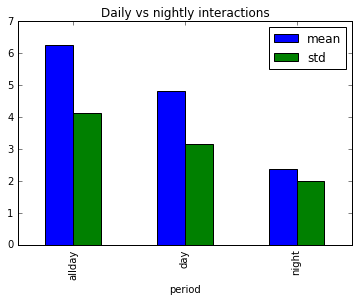

In [13]:
# Plot the results.
%matplotlib inline

interactions_splitByDay = bc.individual.number_of_interactions(B, groupby='day', split_day=True, interaction='call')

interactions_split = []
for period, values in interactions_splitByDay['allweek'].items():
    interactions_split.append([period, values['call']['mean'], values['call']['std']])

interactions_split = pd.DataFrame(interactions_split,columns=['period', 'mean','std'])    
_ = interactions_split.plot(kind='bar' , x='period', title='Daily vs nightly interactions')

Split_day is now introduced as well to view all available strata.

In [14]:
bc.individual.number_of_interactions(B, groupby='day', split_week=True, split_day=True, interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 6.2560975609756095, 
                "std": 4.119587285774633
            }
        }, 
        "day": {
            "call": {
                "mean": 4.8076923076923075, 
                "std": 3.1462541517456484
            }
        }, 
        "night": {
            "call": {
                "mean": 2.3793103448275863, 
                "std": 1.9811837823756178
            }
        }
    }, 
    "weekday": {
        "allday": {
            "call": {
                "mean": 6.5, 
                "std": 3.947573094109004
            }
        }, 
        "day": {
            "call": {
                "mean": 4.964912280701754, 
                "std": 3.1453943622477163
            }
        }, 
        "night": {
            "call": {
                "mean": 2.276595744680851, 
                "std": 1.5804945046189909
            }
        }
    }, 
    "weekend": {
        "allday": {
            

> **Note**:

> The output is as expected. The number of interactions is higher for “day” compared to “night”, as well as for “weekday” compared to “weekend”.

### 2.2.3 Other indicators
Machine learning algorithms utilize features for prediction and clustering tasks. The difficulty arises in manually generating these features, however, using libraries to generate them on your behalf can significantly speed up and standardize the process.

Two additional features will be demonstrated here. You can refer to the bandicoot reference material for further additional available features.

#### Active days (days with at least one interaction)

In [15]:
# Active days.
bc.individual.active_days(B)

{
    "allweek": {
        "allday": {
            "callandtext": {
                "mean": 6.068181818181818, 
                "std": 1.3211174208485112
            }
        }
    }
}

> **Note**: 

> Remember that Bandicoot defaults to grouping by week if the grouping is not explicitly specified.

#### Number of contacts
This number can be interesting, as some research suggests that it is predictable for humans and in the long run it is almost constant for any individual. Please review the articles below for additional information.
- [Your Brain Limits You to Just Five BFFs](https://www.technologyreview.com/s/601369/your-brain-limits-you-to-just-five-bffs/)
- [Limited communication capacity unveils strategies for human interaction](http://www.nature.com/articles/srep01950)

In [16]:
# Number of contacts. 
bc.individual.number_of_contacts(B, split_week=True)

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 10.857142857142858, 
                "std": 3.4404555939406554
            }, 
            "text": {
                "mean": 6.5, 
                "std": 2.2309802166923687
            }
        }
    }, 
    "weekday": {
        "allday": {
            "call": {
                "mean": 9.384615384615385, 
                "std": 2.020603928702107
            }, 
            "text": {
                "mean": 5.604651162790698, 
                "std": 1.7932630370843723
            }
        }
    }, 
    "weekend": {
        "allday": {
            "call": {
                "mean": 4.3076923076923075, 
                "std": 2.16207220347003
            }, 
            "text": {
                "mean": 3.225, 
                "std": 1.8505066873697054
            }
        }
    }
}

> **Note**:

> It looks like there might be a difference between the number of people contacted by phone between the weekend and weekdays.

#### All available features
Bandicoot currently contains 1442 features. You can obtain a quick overview of the features for this dataset using the bandicoot [utils.all](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.utils.all.html#bandicoot.utils.all) function. The three categories of indicators are individual, spatial, and network-related features.

In [17]:
bc.utils.all(B) #Very useful

{
    "name": "sp10-01-08", 
    "reporting": {
        "antennas_path": "../data/bandicoot/antennas.csv", 
        "attributes_path": None, 
        "recharges_path": None, 
        "version": "0.5.3", 
        "code_signature": "9448acf6f41035dc77ec1442688b811e522ffb4d", 
        "groupby": "week", 
        "split_week": false, 
        "split_day": false, 
        "start_time": "2010-07-23 10:02:55", 
        "end_time": "2011-05-27 16:23:21", 
        "night_start": "19:00:00", 
        "night_end": "07:00:00", 
        "weekend": [
            6, 
            7
        ], 
        "number_of_records": 3018, 
        "number_of_antennas": 27, 
        "number_of_recharges": 0, 
        "bins": 45, 
        "bins_with_data": 44, 
        "bins_without_data": 1, 
        "has_call": true, 
        "has_text": true, 
        "has_home": true, 
        "has_recharges": false, 
        "has_attributes": false, 
        "has_network": false, 
        "percent_records_missing_location": 1

> **Note**:

> Great, just "The reporting variables allows you to better understand the nature and origin of the data as well as which computations have been performed (which version of the code etc). In earlier modules we started to perform some manual checks on data quality. Experience will teach you that this step always takes longer than anticipated and requires significant effort to determine the relevant questions and to execute them. Using a standardized library such as bandicoot saves both time in analyzing datasets and spotting issues, and makes the actions repeatable or comparable with other datasets or analyses.

# 3. Visualization with Bandicoot

The visualization demonstrated in Module 2 will be repeated now that you have more background information on the toolbox and its capabilities. As Yves-Alexandre de Montjoye mentioned in the video content, visualization is a powerful tool, not just for communicating your final results, but also in terms of checking the validity of your data, to identify errors and outliers, as well as in identifying useful patterns visually that hides in aggregated datasets.

In [18]:
# Import the relevant libraries.
import os
from IPython.display import IFrame

# Set the path to store the visualization.
viz_path = os.path.dirname(os.path.realpath(__name__)) + '/viz'

# Create the visualization.
bc.visualization.export(B, viz_path)

# Display the visualization in a frame within this notebook.
IFrame("./viz/index.html", "100%", 700)

Successfully exported the visualization to /home/ubuntu/projects/module_5/viz


> **Note**:

> We use "IFrame" to serve the results in the notebook. You can also serve the results as web page using bandicoot provided tools. This function is not demonstrated in this class as the required ports have not been opened on the AWS virtual analysis environment.

> You can review the [quickstart guide](http://bandicoot.mit.edu/docs/quickstart.html#visualizing-a-user) for more detail on the "bc.visualization.run(U)" command. You can use this function to serve the visualization as a web page if you choose to install bandicoot on infrastructure where you do have access to the default port which is 4242. (This port is not open on your AWS virtual analysis environment.)

# 4. Graphs and matrices

This section contains network indicators, a gender assortativity example, and a brief demonstration on how to use Bandicoot to generate input for visualizations using NetworkX. You started the course with Professor Pentland describing general patterns in behavior that are observed between individuals. Understanding the individual as a part of a network is an extremely useful way to evaluate how they resemble or do not resemble their friends, as well as the role they play in their network or community.

In our current dataset, “Friends and Family”, the majority of interactions take place outside of the population in the study, therefore performing the calculations on this dataset does not make sense. This is because the data is not representative of the full network of contacts. In a commercial application you would most likely encounter a similar situation as there are multiple carriers, each with only a portion of the total market share. The figures differ per country but typically fall in the range of 10-30% market share for the main (dominant) carriers.

You need to prepare a separate, trimmed, dataset to demonstrate this example.

A useful feature of Bandicoot, is that it is very quick to analyze a user's ego network, or individual focus node, if the input data is properly formatted. You start by loading the "ego" in question to a Bandicoot object. You need to set the network parameter to "True". Bandicoot will attempt to extract all "ego" interaction data, as well as do the network analysis for the data contained in the specified network folder.

## 4.1 Load the data

In [19]:
# Specify the network folder containing all the data.
network_folder  = '../data/bandicoot/network_records/'

# Create Bandicoot object.
BN = bc.read_csv(user_id, network_folder, attributes_path='../data/bandicoot/attributes',network=True)

         call_duration: 356 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.


[x] 1420 records from 2010-07-23 10:02:55 to 2011-05-27 14:44:21
[x] 7 contacts
[x] 2 attributes
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[ ] No calls
[x] Has network


The bandicoot function loads the data, provides summary information and removes the records that are not of interest in the analysis. Performing the data cleansing steps are typically time consuming and prone to error or inconsistencies. The graph data is stored as an adjacency matrix.

> **Note**:

> You will recall adjacency matrices from Module 4 as a useful mechanism to represent finite graphs. Bandicoot stores graph information in an adjacency matrix, and said matrix indexes in a different object. Once the data has been loaded, you can start exploring the graph.

## 4.2 Network indicators

In [20]:
# Index of the adjacency matrix - user_ids participating in the network.
node_labels = bc.network.matrix_index(BN)
node_labels

['sp10-01-08',
 'fa10-01-14',
 'fa10-01-20',
 'sp10-01-07',
 'sp10-01-38',
 'sp10-01-39',
 'sp10-01-41',
 'sp10-01-49']

There are several types of adjacency matrices available in Bandicoot, namely:

* `bc.network.matrix_directed_weighted(network_user)`
* `bc.network.matrix_directed_unweighted(network_user)`
* `bc.network.matrix_undirected_weighted(network_user)`
* `bc.network.matrix_undirected_unweighted(network_user)`

You can review [Bandicoot network documentation](http://bandicoot.mit.edu/docs/reference/bandicoot.network.html) for additional information.

In [21]:
# Directed unweighted matrix.
directed_unweighted = bc.network.matrix_directed_unweighted(BN)
directed_unweighted

[[0, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 1, 0],
 [1, 0, 0, 1, 0, 1, 1, 0],
 [1, 1, 0, 1, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 1, 0]]

In [22]:
# Undirected weighted matrix.
undirected_weighted = bc.network.matrix_undirected_weighted(BN)
undirected_weighted

[[0, 6, 7, 397, 6, 130, 8, 544],
 [6, 0, 0, 0, 0, 3, 10, 14],
 [7, 0, 0, 0, 0, 0, 0, 0],
 [397, 0, 0, 0, 56, 0, 0, 0],
 [6, 0, 0, 56, 0, 1052, 2, 0],
 [130, 3, 0, 0, 1052, 0, 27, 216],
 [8, 10, 0, 0, 2, 27, 0, 39],
 [544, 14, 0, 0, 0, 216, 39, 0]]

## 4.3 Gender assortativity
This indicator computes the assortativity of nominal attributes. More specifically, it measures the similarity of the current user with his or her correspondents for all bandicoot indicators. For each one, it calculates the variance of the current user’s value with the values for all their correspondents. This indicator measures the homophily of the current user with their correspondents, for each attribute. It returns a value between 0 (no assortativity) and 1 (all the contacts share the same value), which indicates the percentage of contacts sharing the same value.

Let's demonstrate this by reviewing the gender assortativity.

In [23]:
bc.network.assortativity_attributes(BN)['gender']

0.7142857142857143

<br>
<div class="alert alert-info">
<b>Exercise 2 Start.</b>
</div>

### Instructions

In the previous example you obtained a value of 0.714 or 71.4% for gender assortativity. Random behavior would typically deliver a value centered around 50% if you have enough data points. 

> **Question**: Do you think the value of 71.4% is meaningful or relevant?

> Your answer should be a Yes or No, and a short description of what you think the value obtained means in terms of the dataset.

No and Yes. No, 71.43% does not make sense if we consider couples as a man and a woman only. It should be closer to 50/50 since we are observing a population exclusively made of couples. The study should not be biased in gender like this if the couple would have been defined that way. But yes it is relevant and makes sense if couples can include same sex couples. The fact of having or not children, since it is said that half of the couples have children, is not a sufficient indicator of the sexual tendency of the couple since adoption, surrogate mother, insemination aid or IVF is possible for same sex couples. 

Per Wikipedia, "Homophily (i.e., "love of the same") is the tendency of individuals to associate and bond with similar others. The presence of homophily has been discovered in a vast array of network studies." A rate of 71.43% means that 71.4% of contacts were sharing the value of the same gender or were of the same gender.

As shown in the 2011 article of reference, "Social fMRI: Investigating and shaping social mechanisms in the real
world" by Aharonya, Pana, Ipa, Khayal and Pentlanda in the review Pervasive and Mobile Computing, Vol.7, pp. 643-651 (file:///Users/MimiCracra/Downloads/FriendsAndFamily.pdf), "All members of the community are couples, and at least one of the members is affiliated with the university", a major research university in North America, here probably the MIT or Stanford. This “Friends & Family”: community and sub-communities are composed of over 400 residents, approximately half of which have children. Among those the approximately 200 who applied, 130 have been selected to be below the threshold of 150 corresponding to the maximum number of people we can have meaningful contact with, highlighted by Dunbar’s social evolutionary theory as show in the article by Emerging Technology from the arXiv in the MIT Technology Review "Your Brain Limits You to Just Five BFFs" (https://www.technologyreview.com/s/601369/your-brain-limits-you-to-just-five-bffs/). 

Therefore, if I am correct, it all depends on the definition of a couple by researchers:

If we are talking about heterosexual couples, the answer is no, the data is biased since the data collection methodology should have prevent this to happen. Such a dataset would conclude on biased results since men and women have different behaviors. Indeed the issue might be in the next steps of data cleansing and preparation.

If we include homosexual couples, the answer can be yes and the data can be correct.

Question, stupid maybe...: Why only 129 records in the bandicoot network and attributes datasets? And considering the methodology described in the study and excluding the gender issue, why did they refer to only 64 families? 130 participants being all couples should have result in 65 families or couples, not 64.

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 4.4 Ego network visualization

You can use the ego network adjacency matrices for further analyses in NetworkX.

In [24]:
# Load the relevant libraries and set plotting options.
import networkx as nx
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,11)

Create directed unweighted and undirected weighted graphs to visualize the network to better understand the user behaviour as per the examples in section 1.2 of module 4 notebook 2.

In [25]:
# Create the graph objects.
G_directed_unweighted = nx.from_numpy_matrix(np.array(directed_unweighted))
G_undirected_weighted = nx.from_numpy_matrix(np.array(undirected_weighted))
node_labels = dict(enumerate(node_labels))

#### Plot the directed unweighted graph.
This can typically be utilized to better understand the flow or spread of information.

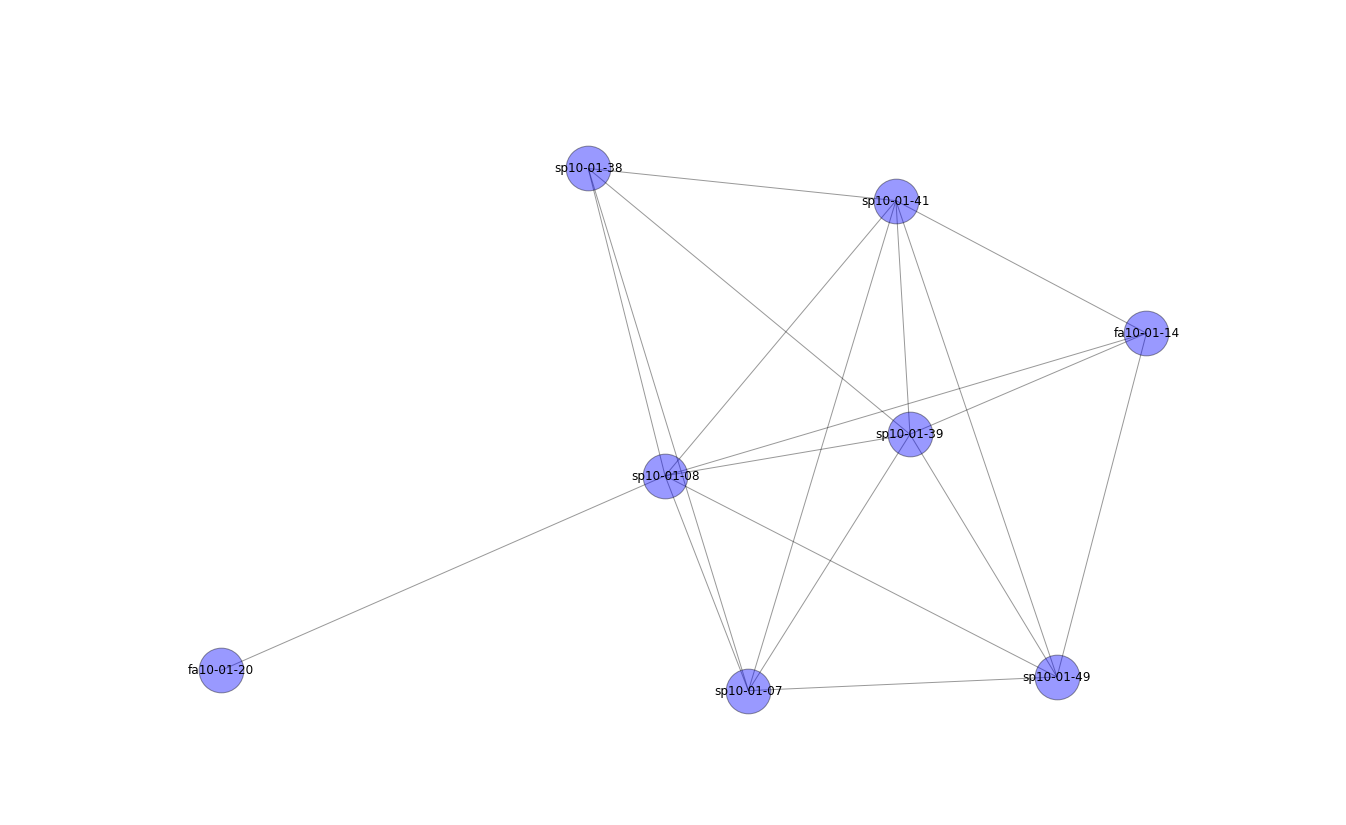

In [26]:
# Plot the graph.
layout = nx.spring_layout(G_directed_unweighted)
nx.draw(G_directed_unweighted, layout, node_color='blue', alpha=0.4, node_size=2000)
_ = nx.draw_networkx_labels(G_directed_unweighted, layout, node_labels)

#### Plot the undirected weighted graph.
This can typically be utilized to better understand the importance of the various individuals and their interactions in the network.

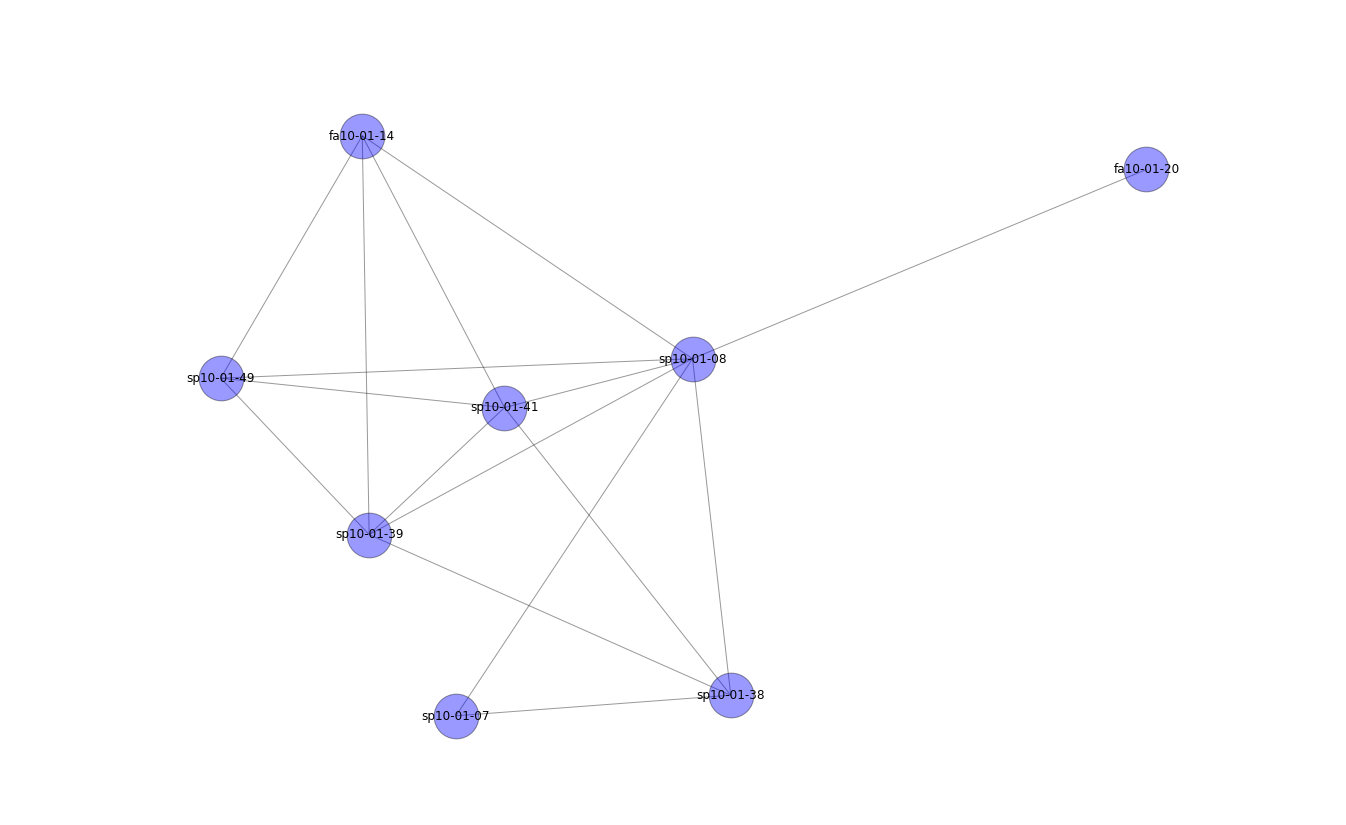

In [27]:
# Plot the graph.
layout = nx.spring_layout(G_directed_unweighted)
nx.draw(G_undirected_weighted, layout, node_color='blue', alpha=0.4, node_size=2000)
_ = nx.draw_networkx_labels(G_undirected_weighted, layout, node_labels)

> **Note**:

> Can you think of use cases for the various networks introduced in module 4? 

> Feel free to discuss these with your fellow students on the forums.

# 5. Data error handling
This section demonstrates some of Bandicoot’s error handling and reporting strategies for some of the "faulty" users.
Some circumstances may require working with CDR records and collected mobile phone metadata that have been corrupted. The reasons for this can be numerous, but typically include: wrong formats, faulty files, empty periods of time, missing users, etc. Bandicoot will not attempt to correct errors as this might lead to incorrect analyses. Correctness is key in data science and bandicoot will:

1. Warn you when you attempt to import corrupted data;
2. Remove faulty records; and
3. Report on more than 30 variables (such as the number of contacts, types of records, records containing location), warning you of potential issues when exporting indicators.

## 5.1 Bandicoot csv import
Importing csv files with bandicoot will produce warnings about:

1. No files containing data being found in the specified path.
2. The percentage of records missing location information.
3. The number of antennas missing geotags (provided the antenna file has been loaded).
4. The fraction of duplicated records.
5. The fraction of calls with an overlap bigger than 5 minutes.


In [28]:
# Set the path and user for demonstration purposes.
antenna_file             = '../data/bandicoot/antennas.csv'
attributes_path          = '../data/bandicoot/attributes/'
records_with_errors_path = '../data/bandicoot/records/'
error_user_id            = 'fa10-01-04'

## 5.2 Error example

In [29]:
errors = bc.read_csv(error_user_id, records_with_errors_path )

[x] 2408 records from 2010-09-20 13:48:57 to 2011-05-23 22:25:08
[x] 54 contacts
[ ] No attribute stored
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


         call_duration: 1458 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.


You can review the errors below to quickly get a view of your dataset. This example includes warnings that are in addition to the missing location and antenna warnings explained earlier. The new warnings include:

1. Missing values of call duration.
2. Duplicate records.
3. Overlapping records.

### 5.2.1 Rows with missing values
These rows are prudently excluded and their details can be examined using `errors.ignored_records`.

In [30]:
errors.ignored_records

{'all': 1458,
 'call_duration': 1458,
 'correspondent_id': 0,
 'datetime': 0,
 'direction': 0,
 'interaction': 0,
 'location': 0}

### 5.2.2 Duplicated records
 These records are retained by default, but you can change this behavior by adding the parameter “drop_duplicates=True” when loading files.
> **Warning**:

> Exercise caution when using this option. The maximum timestamp resolution is one minute, and some of the records that appear to be duplicates may in fact be distinct text messages, or even, although very unlikely, very short calls. As such, it is generally advised that you examine the records before removing them.

In [31]:
errors = bc.read_csv(error_user_id, records_with_errors_path, drop_duplicates=True)

[x] 2008 records from 2010-09-20 13:48:57 to 2011-05-23 22:25:08
[x] 54 contacts
[ ] No attribute stored
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


         call_duration: 1458 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.
Warning! 400 duplicated record(s) were removed.


<br>
<div class="alert alert-info">
<b>Exercise 3 Start.</b>
</div>

### Instructions
 > Data error handling can be a complex task when working with data of any size or volume. 
 
 > 1) Please state three important topics to consider when performing data error handling.
 
 > 2) Also provide us with a short description of your view of items to consider. Your answer should be one or two sentences and can be based on an insight that you reached while completing the course material or from previous experience.

A. To handle errors:

. First a raw original dataset should be kept untouched in a safe location in order to recover the original data if by mistake wrong adjustments are made or data is wrongly removed in the pre-processing step to normalize the data and/or the hygiene stage when we try to reduce the noise to have a clearer signal in the data. After making sure that the data is relevant, recent, has the right range, robustness and reliability, the 5Rs of data quality in Module 1, we have, in the hygiene stage, to make sure that we are not confusing noise and signal. This is key and can happen, so keeping the original data log/record is essential. Besides, keeping a clean original raw data record can save the day when data is just lost or corrupted at any time in the process from data pre-processing/normalization to 

. Second, make sure you really understand the problem to be solved and have a relevant plan and methodology to stick with in order to reach the expected result or goal. To do so, looking at the raw data, its format, its overall content, its fields or attributes and how they interact together, and to visualize these data sets ideally by attribute is always useful. Examined with simple descriptive tools like standard statistical packages or even spreadsheets if the dataset is not above 1,05 million rows, which is the limit of Excel. To identifying systematically suspect data, we can predefine expectations about normal ranges, distribution shapes, and strength of relationships and apply these criteria can be planned beforehand, to be carried out during or shortly after data collection, during data entry, and regularly thereafter. And, ultimately, comparison of the data with the screening criteria can be partly automated to flag dubious data points or patterns.

. Third, understand and have transparent information on the data collection process and the population or sample population characteristics in order to understand the data better, confirm key identifiers, nature of relations between response function and its variables or attributes, potential biases in the process and consecutive effects on results, missing or wrongly formatted data, and errors and issues when they arise or appear in the dataset.

. Fourth remove or correct format if possible, remove duplicates, merged data, overlapping records, records with missing values, lines or row if not meaningful, outliers or excess data if possible and necessary, and ideally keep a record of the errors extracted from the data in a separate file. Data cleaning deals with data problems once they have occurred and some errors deserve priority, but which ones are most important is highly study-specific, which send us back to the importance of the second point above. Error-prevention strategies can reduce many problems but cannot eliminate them.

B.  Items to consider

In two sentences, I would say look at duplicates, merged fields, overlapping records, missing values, rowns or columns, excess data, outliers, logically or physically impossible values or patterns in sets of attributes or attributes distributions, unexpected changes in patterns of attributes, and error signs like $@&#N/A in value fields. 

In a more developped approach, I found a good article describing the data cleansing process where data cleaning is defined as a three-stage process, involving repeated cycles of screening, diagnosing, and editing of suspected data abnormalities (Van den Broeck J, Argeseanu Cunningham S, Eeckels R, Herbst K (2005) Data Cleaning: Detecting, Diagnosing, and Editing Data Abnormalities. PLoS Med 2(10): e267. doi:10.1371/journal.pmed.0020267, http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1198040/). I would as explained above two steps: understanding and raw and errors record keeping.

. Understanding: as explained above, understanding the raw data, our goal and the steps it implies to reach it along with the possible risks in a planned process or methodology. Define study objectives can be very useful to set the required precision of the outcome measures, acceptable error rate, cut offs and, data cleaning resource allocation and budget investment.

. Record keeping: Keep records of original raw data and ideally errors in their original state in a safe place.

. Screening: Distinguish 4 basic types of oddities: lack or excess of data; outliers, including inconsistencies; strange patterns; and unexpected analysis results and other types of inferences and abstractions. This phase corresponds to the second point above. This helps to predefine screening cutoffs (soft cutoffs) as explained in the same paragraph.

. Diagnosing: In this phase, the purpose is to clarify the true nature of the worrisome data points, patterns, and statistics. Possible diagnoses for each data point are as follows: erroneous, true extreme, true normal (i.e, the prior expectation was incorrect), or idiopathic (i.e., no explanation found, but still suspect). Some data points are clearly logically, physically or biologically impossible. And categorize them can help. Cutoffs for immediate diagnosis of error (hard cutoffs) can be defined to identify suspected errors falling in between the soft and hard cutoffs. In these cases, it is necessary to apply a combination of diagnostic procedures:

"One procedure is to go to previous stages of the data flow to see whether a value is consistently the same. This requires access to well-archived and documented data with justifications for any changes made at any stage."

"A second procedure is to look for information that could confirm the true extreme status of an outlying data point. 

"A third procedure is to collect additional information, e.g., question the interviewer/measurer about what may have happened and, if possible, repeat the measurement. Such procedures can only happen if data cleaning starts soon after data collection, and sometimes re-measuring is only valuable very shortly after the initial measurement." and limited by deadlines, time lapse, time frame or budget. 

During the diagnostic phase, we can be forced to reconsider prior expectations, goals, methods and/or review quality assurance procedures. It is an intensive phase in terms of labor, budget, logistics, and personnel requirements and this phase is typically underestimated or even neglected at the study design stage. Automated query generation, flagging, and automated comparison of successive datasets can be used to lower costs and speed up the necessary steps of diagnosing.

. Editing or treatment: Decide what to do with problematic observations and chose between correcting, deleting, or leaving unchanged the flagged data points. In general rule: 

Impossible values are never left unchanged, but corrected if a correct value can be found, otherwise deleted.
With true extreme values or values that are still suspect after the diagnostic phase we need to further examine the influence of such data points, individually and as a group, on analysis results before deciding whether or not to leave the data unchanged using statistical methods to help evaluate the influence of such data points on regression parameters. But some authors have recommended that true extreme values should always stay in the analysis. "In practice, many exceptions are made to that rule. The investigator may not want to consider the effect of true extreme values if they result from an unanticipated extraneous process. This becomes an a posteriori exclusion criterion and the data points should be reported as “excluded from analysis”. Alternatively, it may be that the protocol-prescribed exclusion criteria were inadvertently not applied in some cases."

. Documenting: Documenting each step of the process is essential: tests, location of metadata and samples used in the process, along with errors removed from original dataset in raw original format.

Besides, the authors are pointing at a significant advantage of such a serious, planned and documented methodology. "Data cleaning often leads to insight into the nature and severity of error-generating processes. The researcher can then give methodological feedback to operational staff to improve study validity and precision of outcomes. It may be necessary to amend the study protocol, regarding design, timing, observer training, data collection, and quality control procedures. In extreme cases, it may be necessary to restart the study. Programming of data capture, data transformations, and data extractions may need revision, and the analysis strategy should be adapted to include robust estimation or to do separate analyses with and without remaining outliers and/or with and without imputation."

<br>
<div class="alert alert-info">
<b>Exercise 3 End.</b>
</div>

# 6. Loading the full dataset
In this section, you will load the full “Friends and Family” reality commons dataset and compute all the metrics (briefly introduced in section 2.2.3) for all the users. You need to specify a "flat" directory, containing files where each file corresponds to a single user, as input. It is crucial that the record-file naming convention is being observed, i.e. the names of the files are the user IDs and each user's data resides in a separate file.

In [32]:
# View the files in the directory using the operating system list function.
!ls ../data/bandicoot/clean_records/ 

fa10-01-01.csv	fa10-01-27.csv	fa10-01-53.csv	fa10-01-79.csv	sp10-01-29.csv
fa10-01-02.csv	fa10-01-28.csv	fa10-01-54.csv	fa10-01-80.csv	sp10-01-30.csv
fa10-01-03.csv	fa10-01-29.csv	fa10-01-55.csv	fa10-01-81.csv	sp10-01-31.csv
fa10-01-04.csv	fa10-01-30.csv	fa10-01-56.csv	fa10-01-82.csv	sp10-01-32.csv
fa10-01-05.csv	fa10-01-31.csv	fa10-01-57.csv	fa10-01-83.csv	sp10-01-33.csv
fa10-01-06.csv	fa10-01-32.csv	fa10-01-58.csv	fa10-01-85.csv	sp10-01-34.csv
fa10-01-07.csv	fa10-01-33.csv	fa10-01-59.csv	fa10-01-86.csv	sp10-01-35.csv
fa10-01-08.csv	fa10-01-34.csv	fa10-01-60.csv	sp10-01-01.csv	sp10-01-36.csv
fa10-01-09.csv	fa10-01-35.csv	fa10-01-61.csv	sp10-01-02.csv	sp10-01-37.csv
fa10-01-10.csv	fa10-01-36.csv	fa10-01-62.csv	sp10-01-05.csv	sp10-01-38.csv
fa10-01-11.csv	fa10-01-37.csv	fa10-01-63.csv	sp10-01-06.csv	sp10-01-39.csv
fa10-01-12.csv	fa10-01-38.csv	fa10-01-64.csv	sp10-01-07.csv	sp10-01-40.csv
fa10-01-13.csv	fa10-01-39.csv	fa10-01-65.csv	sp10-01-08.csv	sp10-01-41.csv
fa10-01-14.csv	fa10-01-40

## 6.1 Load the files and create a metric
You can review the bandicoot [utils.all](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.utils.all.html#bandicoot.utils.all) page for more detail.

In [33]:
# Load libraries and set path options.
import glob, os
records_path    = '../data/bandicoot/clean_records/'

# Create an empty list and then cycle through each of the available files in the directory to add features.
features = []
for f in glob.glob(records_path + '*.csv'):
    user_id = os.path.basename(f)[:-4]

    try:
        B = bc.read_csv(user_id, records_path, attributes_path=attributes_path, describe=False, warnings=False)
        metrics_dict = bc.utils.all(B, summary='extended', split_day=True, split_week=True)
    except Exception as e:
        metrics_dict = {'name': user_id, 'error': str(e)}

    features.append(metrics_dict)

## 6.2 Save the interactions in a file for future use
> **Note**:

> The application of machine-learning techniques, using a similar dataset, will be explored in the next notebook.

In [34]:
bc.io.to_csv(features, 'all_features.csv')

Successfully exported 129 object(s) to all_features.csv


Before moving on, take a quick look at the results of the pipeline.

#### Review the data for the first user.
Keep in mind that in manual approaches, you would likely have to create each of these features by hand. The process entails thinking about features and reviewing available literature to identify applicable features. These features are used in machine learning techniques (including feature selection) for various use cases.

> **Note**:

> The section below will display a large number of features for the first user. You do not need to review in detail, but we want to emphasise the ease of creation of features and the advantages of computationally optimized functions. These are extremely useful when scaling your analyses to large record sets such as those typically found in the telecommunications industry.

In [35]:
features[:1]

[{
    "name": "sp10-01-45", 
    "reporting": {
        "antennas_path": None, 
        "attributes_path": "../data/bandicoot/attributes/", 
        "recharges_path": "../data/bandicoot/attributes/", 
        "version": "0.5.3", 
        "code_signature": "9448acf6f41035dc77ec1442688b811e522ffb4d", 
        "groupby": "week", 
        "split_week": true, 
        "split_day": true, 
        "start_time": "2010-07-26 23:33:53", 
        "end_time": "2011-05-27 10:19:24", 
        "night_start": "19:00:00", 
        "night_end": "07:00:00", 
        "weekend": [
            6, 
            7
        ], 
        "number_of_records": 1532, 
        "number_of_antennas": 0, 
        "number_of_recharges": 0, 
        "bins": 44, 
        "bins_with_data": 44, 
        "bins_without_data": 0, 
        "has_call": true, 
        "has_text": true, 
        "has_home": true, 
        "has_recharges": false, 
        "has_attributes": true, 
        "has_network": false, 
        "percent_recor

#### Review the number of users.

In [36]:
# Display the length or number of features.
len(features)

129

In [37]:
# To print the list of names contained in features you can uncomment the lines below. This is not required.
for u in features:
    print u['name']

sp10-01-45
fa10-01-53
fa10-01-08
fa10-01-07
fa10-01-31
fa10-01-55
fa10-01-40
sp10-01-09
fa10-01-62
sp10-01-32
fa10-01-04
fa10-01-19
sp10-01-26
fa10-01-44
sp10-01-29
fa10-01-41
fa10-01-35
fa10-01-13
fa10-01-11
fa10-01-69
fa10-01-45
sp10-01-56
fa10-01-82
sp10-01-40
sp10-01-48
sp10-01-55
fa10-01-38
sp10-01-41
fa10-01-73
sp10-01-47
fa10-01-01
sp10-01-31
sp10-01-51
sp10-01-25
fa10-01-50
fa10-01-68
sp10-01-07
sp10-01-44
sp10-01-38
fa10-01-79
fa10-01-85
sp10-01-11
fa10-01-76
fa10-01-78
sp10-01-33
fa10-01-77
fa10-01-06
fa10-01-47
fa10-01-64
fa10-01-14
sp10-01-01
fa10-01-10
fa10-01-71
fa10-01-25
fa10-01-36
sp10-01-13
sp10-01-46
fa10-01-17
fa10-01-56
fa10-01-43
fa10-01-57
fa10-01-20
fa10-01-65
fa10-01-05
fa10-01-24
fa10-01-66
fa10-01-23
fa10-01-21
fa10-01-29
fa10-01-15
fa10-01-61
fa10-01-83
sp10-01-02
sp10-01-18
sp10-01-49
fa10-01-34
sp10-01-05
sp10-01-35
fa10-01-70
fa10-01-22
fa10-01-80
sp10-01-22
sp10-01-16
fa10-01-27
fa10-01-72
fa10-01-33
fa10-01-75
fa10-01-60
sp10-01-39
sp10-01-24
sp10-01-12

# 7. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the online campus.

# 8. References
Jahani, Eaman, Pal Roe Sundsoy, Johannes Bjelland, Asif Iqbal, Alex Pentland, and Yves-Alexandre de Montjoye. 2015. “Predicting Gender from Mobile Phone Metadata.” Paper presented at the Netmob Conference, Massachusetts Institute of Technology, Cambridge, April 8-10.

Aharony, Nadav, Wei Pan, Cory Ip,Inas Khayal, Alex Pentland. 2011. “SocialfMRI: Investigating and shaping social mechanisms in the real world.” Pervasive and Mobile Computing 7:643-659.